## Lab 8 – Dealing with Overfitting
- MNIST dataset
  - Handwritten digits images
  - 28 x 28 greyscale
- Adapted from: https://www.cs.toronto.edu/~lczhang/360/lec/w05/overfit.html

### Load the data into training and validation sets
- For purposes of overfitting, training data will be largely reduced (only 20 images)
- No normalisation is applied yet
- `batch_size` is set to 20
- We will also not use GPU

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

batch_size = 20

# for reproducibility
torch.manual_seed(1)

train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_data = list(train_data)
train_set = train_data[:20]     # 20 images
val_set   = train_data[200:2200]# 2000 images
train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_set,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch

### View a few images

torch.Size([20, 1, 28, 28])
tensor([1, 6, 3, 1, 1, 8, 3, 1, 3, 0, 9, 5, 9, 6, 2, 7, 2, 4, 5, 4])
class labels: tensor([1, 6, 3, 1, 1, 8, 3, 1, 3, 0, 9, 5, 9, 6, 2, 7, 2, 4, 5, 4])


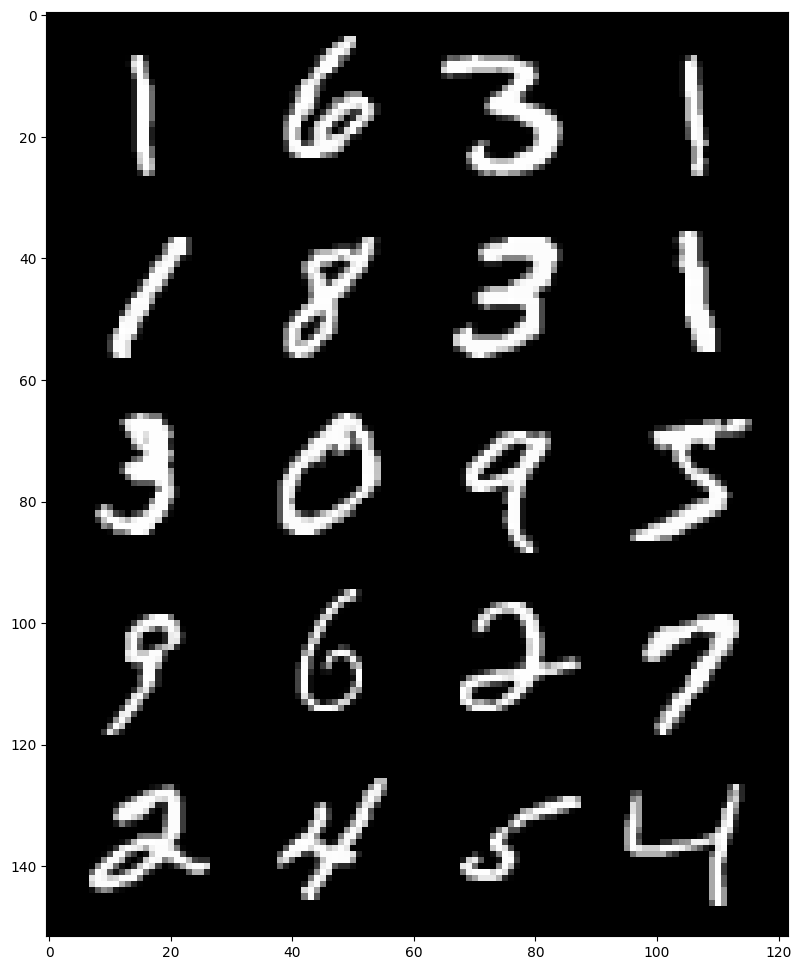

In [61]:
batch = next(iter(train_loader))
images, labels = batch
print(images.shape)
print(labels)

# Create a grid 
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

### Create a NN model

In [63]:
class MNIST_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.reshape(-1, 28 * 28)
        out1 = F.relu(self.layer1(flattened))
        out2 = F.relu(self.layer2(out1))
        output = self.layer3(out2)
        return output

### Function to Calculate Accuracy
- Takes in a model and data set
- Performs a forward pass to get the predicted output label for a batch of 64 images
- Calculates percentage of accuracy of the model on the batch

In [64]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() # For later when batch norm and dropouts are applied during training #
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return 100.0 * correct / total

## Function for Training Loop
- Takes in a model, training and validation sets (required), number of iterations, learning rate and weight decay (default values available if not supplied)
- We will run over 500 iterations in batches of 20
- Lists are created and appended to store training and validation accuracies and losses at every 10th iteration
- Training and validations accuracies and losses are plotted


In [66]:
def train_model(model, train, valid, n_iters=500, learn_rate=0.01, weight_decay=0):
  # Lists to store model's performance information
  iters, losses, train_acc, val_acc = [], [], [], []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

  for i in range(n_iters):
    for images, labels in iter(train_loader):
      model.train() # For Dropout and Batch Norm layers #
      out = model(images)           
      loss = criterion(out, labels) 
      loss.backward()               
      optimizer.step()              
      optimizer.zero_grad()         

      # Save the current training and validation information at every 10th iteration
      if (i+1) % 10 == 0:
          iters.append(i)
          losses.append(float(loss)/batch_size)        # compute *average* loss
          train_acc.append(get_accuracy(model, train)) # compute training accuracy 
          val_acc.append(get_accuracy(model, valid))   # compute validation accuracy

### Training is done. 
### Calculate validation losses by doing forward passes on the validation set and calculating the loss at every 10th iteration.
  val_losses = []
  with torch.no_grad():
    for j in range(n_iters):
      for images, labels in iter(val_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
      if (j+1) % 10 == 0:
        val_losses.append(float(loss)/batch_size) # compute and save validation loss

    max_acc = max(val_acc)
    max_acc_idx = val_acc.index(max(val_acc))

### Plot Training Loss, Accuracy and Validation Accuracy
  print(f'Plotting')
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.plot(iters, val_losses, label="Validation") 
  plt.xlabel("Iterations")
  plt.ylabel("Loss")

  plt.subplot(1,2,2)
  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  print(f"Final Training Loss: {losses[-1]:.4f}")
  print(f"Final Validation Loss: {val_losses[-1]:.4f}")
  print(f"Maximum Validation Accuracy: {max_acc}, iterations : {max_acc_idx}")

### 1. Build A Basic Model
- Uses 20 images for training data, contained in `train_set`
- Uses 2000 images for validation data, contained in `val_set`
- Trains over 500 iterations

Plotting


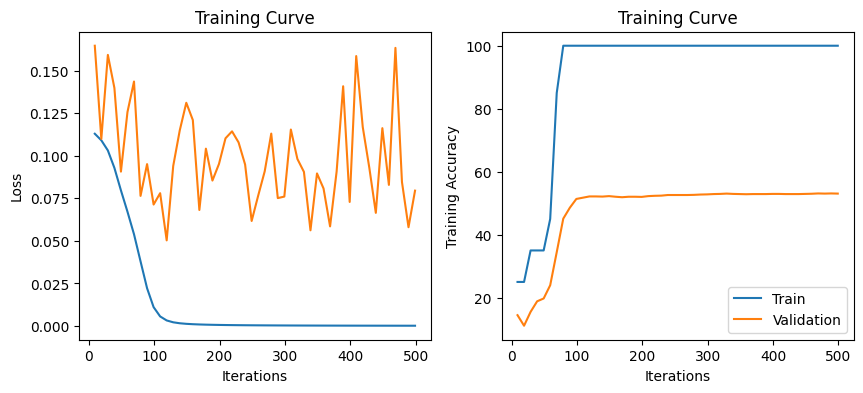

Final Training Accuracy: 100.0
Final Validation Accuracy: 53.05
Final Training Loss: 0.0001
Final Validation Loss: 0.0796
Maximum Validation Accuracy: 53.1, iterations : 46


In [69]:
model = MNIST_DNN()
train_model(model, train_set, val_set)

In [70]:
# Based on the plotted graphs, answer the following questions:

# Q1. What is the final loss of the training set and roughly at which iteration was this achieved? 
# 0.0001, slightly over 100 iterations.

# Q2. What is the final accuracy of the training set and roughly at which iteration was this achieved? 
# 100.0, slightly over 100 iterations.

# Q3. What do these values tell you about the model's performance on the training data?
# This exhibits overfitting. The validation accuracy converged at about 53%, 
# but the training accuracy converged to 100 at the same time as the training loss converged to 
# almost zero at about 100th iteration. This means that the model has become completely suitable for training data,
# but the validation set is not accurately classified. This is because the model reflects irrelevant features 
# present in prediction and training data.

# Q4. What is the model's final accuracy on the validation set?
# 53.05

# Q5. Would more iterations help make a better model? Why?
# No. Although training has progressed enough to fully reflect the training data by converging the training loss to almost zero.
# As model reflects irrelevant features for prediction, the validation accuracy of model is low and 
# the simple increase in the number of iterations without modification of the learning process does not make the model better.

# Q6. Would this model work well on classifying other handwritten digits? Why?
# No. This model cannnot classify the validation set well, and overfiitted for training data. 
# Therefore, the actual handwriting will also be difficult to predict.

### 2. Add Normalisation and Weight Decay
- Our basic model gets to around 52-55% accuracy on the validation set.
- Normalising the inputs will ensure the spread of the values are within a certain range. For example, normalising with mean value 0.5 and std 0.5 subtracts mean (0.5) from each pixel, and divides the result by std (0.5). So, each pixel intensity will be in the range `[-1, 1]`.
- Weight decay penalises large weights. We avoid large weights because large weights mean that the prediction relies a lot on the content of one pixel, or on one unit. Intuitively, the classification of an image should NOT depend heavily on the content of one pixel, or even a few pixels.





In [ ]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # normalisation
        ])

# for reproducibility
torch.manual_seed(1)

# Reload data with normalisation
train_data = datasets.MNIST('./data', train=True, download=False, transform=transform)
train_data = list(train_data)
train_set = train_data[:20]     # 20 images
val_set   = train_data[200:2200]# 2000 images

train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch


### Train a model with Normalisation and Weight Decay
- `train_set` and `val_set` have their inputs normalised
- `weight_decay` is set to 0.001

Plotting


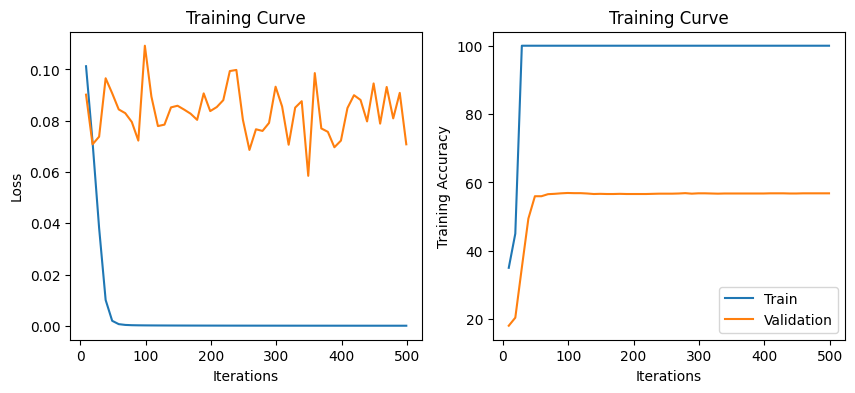

Final Training Accuracy: 100.0
Final Validation Accuracy: 56.8
Final Training Loss: 0.0001
Final Validation Loss: 0.0708
Maximum Validation Accuracy: 56.9, iterations : 9


In [ ]:
model = MNIST_DNN()
train_model(model, train_set, val_set, weight_decay=0.001)

### 3. Add Dropouts
- Randomly "zero out", or "remove" a portion of neurons from each training iteration (with a probability of 40%)
- In different iterations of training, we will drop out a different set of neurons
- Prevents weights from being overly dependent on each other, e.g. one weight could be unnecessarily large to compensate for another unnecessarily large weight with the opposite sign. Weights are encouraged to be "more independent" of one another
- During validation, we will not drop out any neurons. This means that our training time and test time behaviour of dropout layers are different. In the code for the functions `train_model()` and `get_accuracy()`, we use `model.train()` and `model.eval()` to flag whether we want the model's training behaviour, or test time behaviour.

In [ ]:
class MNIST_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout = nn.Dropout(0.4) # drop out layer with 40% chance of deactivating a neuron
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        layer1 = self.dropout(F.relu(self.layer1(flattened)))
        layer2 = self.dropout(F.relu(self.layer2(layer1)))
        output = self.layer3(layer2)
        return output

### Build a new model with Dropouts
- In addition to normalisation and weight decay

Plotting


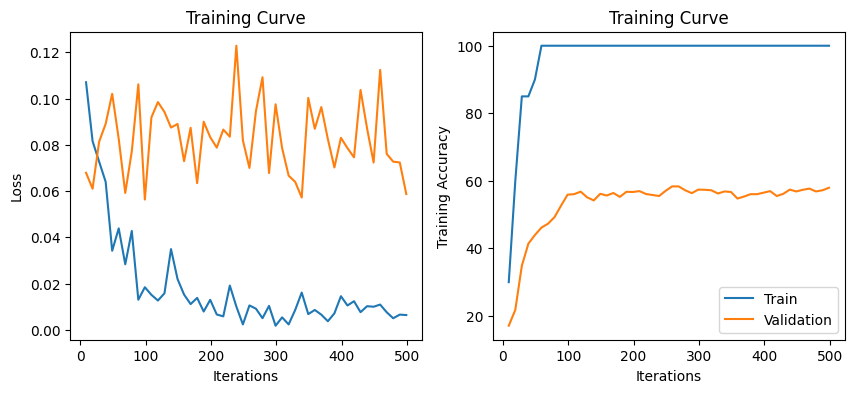

Final Training Accuracy: 100.0
Final Validation Accuracy: 57.95
Final Training Loss: 0.0064
Final Validation Loss: 0.0587
Maximum Validation Accuracy: 58.35, iterations : 25


In [ ]:
model = MNIST_Dropout()
train_model(model, train_set, val_set, weight_decay=0.001)

In [ ]:
# Answer the following questions
# Q7. What is the best validation accuracy and when was it achieved?
# maximum accuracy : 56.45, 41 iterations. 
# * Some modifications to the train_model function

# Q8. Is the validation accuracy a bit better with dropouts, normalisation and weight decay?
# Yes, validation accuracy has been improved has been made from 56.9 to 58.35.

## Add Batch Norm
- Normalise the hidden layer inputs
- Add batch norm BEFORE activation and dropout


In [ ]:
class MNIST_Dropout_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.bn1 = nn.BatchNorm1d(num_features=50)
        self.layer2 = nn.Linear(50, 20)
        # Q9.
        self.bn2 = nn.BatchNorm1d(num_features=20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout = nn.Dropout(0.4) # drop out layer with 40% dropped out neuron

    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        # Q10. Add batch norm to layer1 and layer2
        out1 = self.dropout(F.relu(self.bn1(self.layer1(flattened))))
        out2 = self.dropout(F.relu(self.bn2(self.layer2(out1))))
        output = self.layer3(out2)
        return output

Plotting


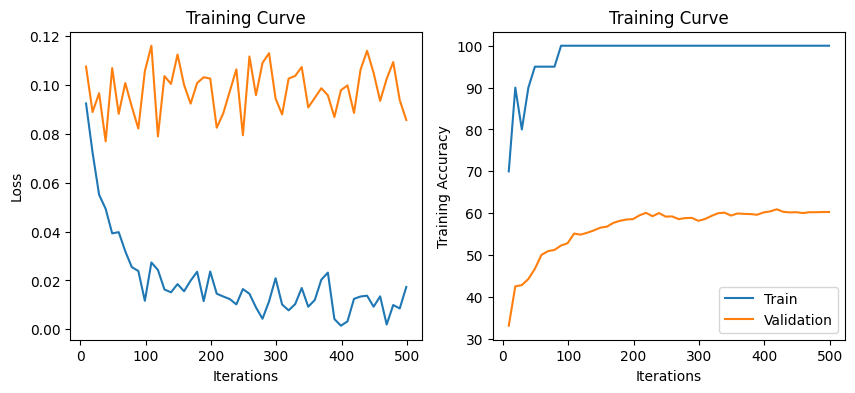

Final Training Accuracy: 100.0
Final Validation Accuracy: 60.3
Final Training Loss: 0.0173
Final Validation Loss: 0.0857
Maximum Validation Accuracy: 60.95, iterations : 41


In [ ]:
model = MNIST_Dropout_BN()
train_model(model, train_set, val_set, weight_decay=0.001)

### Q11. EXERCISE: Use Convolutions with Batch Norms
- Use the **same training and validation data** set loading as before, i.e. you do not have to load the data again
- Add convolutions to your NN, as well as batch norms
- Remember that BatchNorm1d accepts 2D or 3D inputs while BatchNorm2d only accepts 4D inputs
- Use BatchNorm2d with Conv2d layers.
- Use Dropouts as well to get a model with better validation accuracy
- Plot the graph of your final training and validation accuracies and losses (you may want to call `train_model()`)
- Extra: play around with the hyper parameters such as weight decay, learning, rate, etc. to help improve the model's performance


In [76]:
# Q12. Feel free to reflect on your experiences in overcoming overfitting during this lab.
class MNIST_Conv_with_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout2d(p=0.4),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(7*7*128, 512), # 256*4x4
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        output = self.fc_layer(x)
        return output

Plotting


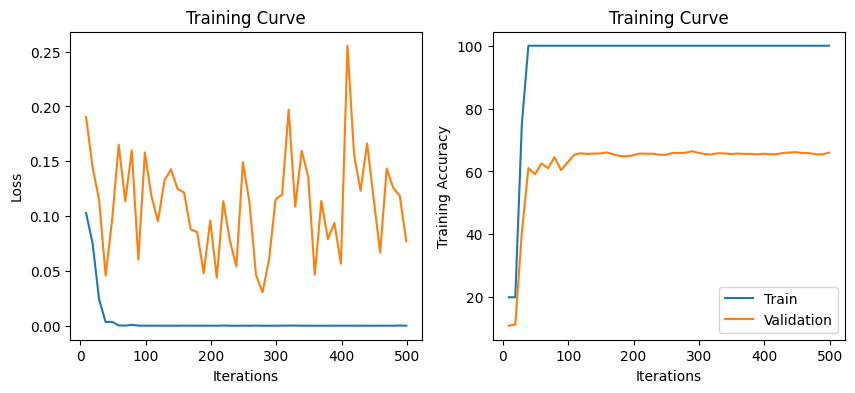

Final Training Accuracy: 100.0
Final Validation Accuracy: 66.0
Final Training Loss: 0.0000
Final Validation Loss: 0.0770
Maximum Validation Accuracy: 66.45, iterations : 28


In [77]:
model = MNIST_Conv_with_BN()
train_model(model, train_set, val_set, weight_decay=0.001)